<a href="https://colab.research.google.com/github/Herdol/Federated_Learning/blob/main/Federated_Meta_Learning/Pytorch_MNIST_FL(Reptile)_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Multi-task Learning simulator 
In this simulation I compared the performance of learning from scratch, reptile algorithm and federated meta (reptile) learning. 
## Simulation setup
Simulation hyperparameters can be changed in the beginning of code. Neural network model is same for all three scenarios. Simulation setups are,
### Learning from scratch
Single learner tries to learn a task in K-shot with randomly initiated model weights.
### Reptile algorithm
Single learner has a model which is trained for two other tasks. Then, it tries to converge third task in  K-shot.
### Federated meta learning
A cluster of learners train their models with two tasks with Reptile algorithm. After each learning cycle, they aggregate their models in a server. After first phase of learning completed, they begin to converge for the third task collaboratively. In K-shot they aggregate their models after each step of 'k' .

## Change log
- Multi headed CNN network converted into 1 headed.
- Update failure between steps has been fixed.

## Library imports and data preparation
Necessary libraries are imported here. Data allocation for the workers are also arranged here. In order to change the number of workers, simply change this line at ths second code block: 
```Python
  num_worker= X
```


In [ ]:
!pip install wandb --upgrade

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict, defaultdict
from sys import getsizeof
import math
import itertools
from scipy.spatial import distance
import time
import matplotlib.pyplot as plt
import wandb
from torch import nn, autograd as ag
import torch.optim as optim
from copy import deepcopy
import pickle

In [ ]:
wandb.login()
wandb.init(project="Scratch_Reptile_Federated_v1", name="accuracy metrics")

wandb: Currently logged in as: herdol (use `wandb login --relogin` to force relogin)


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# The codes below fix the HTTP 503: Forbidden error while downloading MNIST
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#######################################################
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

In [ ]:
#@title Hyperparameters of simulation
num_worker=20 #@param 
Meta_step_number = 20 #@param {type:"slider", min:2, max:100, step:1}
Batch_size = 40 #@param {type:"slider", min:5, max:300, step:1}
Epoch=20 #@param 
Beta=0.1 #@param Meta step size
K_shot=60 #@param
 
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 400 # number of outer updates; each iteration we sample one task and update on it

In [ ]:
wandb.config = {
  "learning_rate": innerstepsize,
  "inner iteration": Meta_step_number,
  "outer iterations": niterations,
  "batch_size": Batch_size,
  "number of suers": num_worker,
  "K-Shot": K_shot

}

In [ ]:
n = 60000  # how many total elements you have
n_test = int( n * .05 )  # number of test/val elements
n_train = 5000
idx_train = list(range(50000))
idx_test = list(range(10000))
train_idx=[]
test_idx=[]
train_set=[]
wtd=int(len(idx_train)/num_worker) #Worker Train data count for an individual node
wtec=int(len(idx_test)/num_worker) #Worker Test data count for an individual node
for widx in range(num_worker):
  train_idx=idx_train[widx*wtd:(widx+1)*wtd]
  test_idx=idx_test[widx*wtec:(widx+1)*wtec]
  train_set.append(torch.utils.data.Subset(trainset, train_idx))
  #testset.append(torch.utils.data.Subset(testset, test_idx))

In [ ]:
model_scratch = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 100),
    nn.ReLU(),
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 2)
)
model_reptile = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 100),
    nn.ReLU(),
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 2)
)
model_federated_meta = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 100),
    nn.ReLU(),
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 2)
)

In [ ]:


'''#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
Learning_rate=0.01
optimizer_scratch = optim.SGD(net_scratch.parameters(), lr=Learning_rate)
optimizer_meta = optim.SGD(net_meta.parameters(), lr=Learning_rate)
optimizer_Fed_meta = optim.SGD(net_Fed_meta.parameters(), lr=Learning_rate)'''

'#criterion = nn.CrossEntropyLoss()\ncriterion = nn.MSELoss()\nLearning_rate=0.01\noptimizer_scratch = optim.SGD(net_scratch.parameters(), lr=Learning_rate)\noptimizer_meta = optim.SGD(net_meta.parameters(), lr=Learning_rate)\noptimizer_Fed_meta = optim.SGD(net_Fed_meta.parameters(), lr=Learning_rate)'

In [ ]:
def totorch(x):
    return ag.Variable(torch.Tensor(x))

def train_on_batch(x, y,model):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x,model):
    x = totorch(x)
    return model(x).data.numpy()

## Utility Functions
Necessary functions are defined under this section.

In [ ]:
def FedAvg(Weights,num_worker):
  #Peer-to-Peer aggregation
  W1=Weights[0]
  FedAvg_result={}
  #print(getsizeof(FedAvg))
  for wei in W1:
    #print(wei)
    FedAvg_result[wei]=W1[wei]*0
    #print(FedAvg) #Clear the variable.
  for widx in range(num_worker):
    for wei in W1:
      temp_weights=Weights[widx]
      FedAvg_result[wei]+= temp_weights[wei]/num_worker

  return FedAvg_result

In [ ]:
def totorch(x):
    return ag.Variable(torch.Tensor(x))

## MAML label transformation
Labels in MNIST dataset will be represented with 4 digit label which are:
$$ [Odd,even,small,large] $$


In [ ]:
def Meta_labels(labels,Task):
  """
  This function transforms MNIST labels into spesific task labels. Tasks classify the numbers if they are
  1) Odd or Even?
  2) Smaller or Larger than 5?
  3) Product of 3?
  """
  temp=[]
  if Task==1: # Odd or even
    Transformer_matrix=[[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0]]
  elif Task==2: # Smaller or larger than 5
    Transformer_matrix=[[1,0],[1,0],[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1],[0,1]]
  elif Task==3: # Product of 3
    Transformer_matrix=[[1,0],[0,1],[0,1],[1,0],[0,1],[0,1],[1,0],[0,1],[0,1],[1,0]]
  else:
    print('Task is out borders')

  for i in labels:
    temp.append(Transformer_matrix[i])
  maml_labels=torch.tensor(temp)
  return maml_labels

## Performance parameter calculations
The key performance values are listed below. 
- Precision = TruePositives / (TruePositives + FalsePositives)
- Recall = TruePositives / (TruePositives + FalseNegatives)
- F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
def extractor(label,out):
  TP, FP, TN, FN = 0,0,0,0
  
  #label=torch.tensor(label,dtype=torch.float32)
  #out=torch.tensor(out,dtype=torch.float32)
  for idx in range(len(label)):
    if out[idx][0]>=out[idx][1] and label[idx][0]==1:
      TP+=1
    elif label[idx][0]==0 and out[idx][0]>=out[idx][1]:
      FP+=1
    elif label[idx][0]==0 and out[idx][0]<=out[idx][1]:
      TN+=1
    elif label[idx][0]==1 and out[idx][0]<=out[idx][1]:
      FN+=1
    
  #print("TP {} FP {} TN{} FN{}".format(TP, FP, TN, FN))
  return TP,FP,TN,FN

def Accuracy_calculation(TP,FP,TN,FN):
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  fscore=(2 * precision * recall) / (precision + recall)

  return precision,recall,fscore

## Training process
Reptile algorithm is performed in this cell. There are 9 workers in this scenario. First 3 are trained to solve odd, even task. Second 3 train to solve small or larger task. Last 3 trains to solve these with unseen digits 8 and 9. 

### Learning from scratch

In [ ]:
wandb.watch(model_scratch,log="all",log_freq=10)
Model_Structure = deepcopy(model_scratch.state_dict())
weights_dictionary=defaultdict(list)

precision_log_scratch,recall_log_scratch,fscore_log_scratch=[],[],[]
TP_total,FP_total,TN_total,FN_total=0,0,0,0
# Reptile training loop
for j in range(K_shot):
    scratch_weights_before = deepcopy(model_scratch.state_dict())
    Test_loss=[]
    #net_test.state_dict=weights_dict#[widx]
    # Do SGD on this task
    #inds = rng.permutation(len(x_all))
    testing_indicies=np.arange(Batch_size*j,len(testset))
    test_subset=torch.utils.data.Subset(testset,testing_indicies)
    testloader=torch.utils.data.DataLoader(test_subset, batch_size=Batch_size,
                                              shuffle=False, num_workers=2)
    for i, data in enumerate(testloader,0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs=inputs.view([-1,784]) #Flattening
      labels_maml=Meta_labels(labels,3)#Initial adaptaion to task 3
      train_on_batch(inputs, labels_maml.float(),model_scratch)
      outputs=model_scratch(inputs)
      TP,FP,TN,FN = extractor(labels_maml,outputs)
      TP_total,FP_total,TN_total,FN_total=np.add([TP_total,FP_total,TN_total,FN_total],[TP,FP,TN,FN])
      precision,recall,fscore=Accuracy_calculation(TP_total,FP_total,TN_total,FN_total)
      
      weights_after = model_scratch.state_dict()
      

      if i ==Meta_step_number:
        precision_log_scratch.append(precision)
        recall_log_scratch.append(recall)
        fscore_log_scratch.append(fscore)
        wandb.log({"precision_log_scratch": precision,
           "recall_log_scratch": recall,
           "fscore_log_scratch": fscore},step=j)
        break
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
torch.onnx.export(model_scratch, inputs, "model_scratch.onnx")
wandb.save("model_scratch.onnx")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


['/content/wandb/run-20220117_085242-cbrkus1b/files/model_scratch.onnx']

In [ ]:
arr=[precision_log_scratch, recall_log_scratch, fscore_log_scratch]

with open('learn_scratch.pkl','wb') as f:
  pickle.dump(arr, f)

with open('learn_scratch.pkl','rb') as f:
  x = pickle.load(f)
  #print(x.shape)

### Vanilla Reptile algorithm

In [ ]:
innerepochs=1
niterations=300
# Reptile training loop
for iteration in range(niterations):
    reptile_weights_before = deepcopy(model_reptile.state_dict())
    training_indicies=np.arange(Batch_size*iteration,len(train_set[0]))
    Training_subset=torch.utils.data.Subset(train_set[widx],training_indicies)
    trainloader1=torch.utils.data.DataLoader(train_set[widx],
                                            batch_size=Batch_size,shuffle=True, num_workers=2)
    for _ in range(innerepochs):
      for i, data in enumerate(testloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.view([-1,784]) #Flattening
        labels_maml=Meta_labels(labels,1)#Initial training for task 1
        train_on_batch(inputs, labels_maml.float(),model_scratch)
        labels_maml=Meta_labels(labels,2)#Initial training for task 2
        train_on_batch(inputs, labels_maml.float(),model_scratch)
        outputs=model_reptile(inputs)
        if i ==Meta_step_number:

          reptile_weights_after = model_reptile.state_dict()

          break
    reptile_weights_after = model_reptile.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model_reptile.load_state_dict({name : 
        reptile_weights_before[name] + (reptile_weights_after[name] - reptile_weights_before[name]) * Beta 
        for name in reptile_weights_before})
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    #weights_after = model.state_dict()
    #outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule

     

Retile algorithm adaptation test

In [ ]:
precision_log_reptile,recall_log_reptile,fscore_log_reptile=[],[],[]
wandb.watch(model_reptile,log="all",log_freq=10)
for j in range(K_shot):
    TP_total,FP_total,TN_total,FN_total=0,0,0,0
    scratch_weights_before = deepcopy(model_reptile.state_dict())
    #net_test.state_dict=weights_dict#[widx]
    # Do SGD on this task
    testing_indicies=np.arange(Batch_size*j,len(testset))
    test_subset=torch.utils.data.Subset(testset,testing_indicies)
    testloader=torch.utils.data.DataLoader(test_subset, batch_size=Batch_size,
                                              shuffle=False, num_workers=2)
    for i, data in enumerate(testloader,0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs=inputs.view([-1,784]) #Flattening
      labels_maml=Meta_labels(labels,3)#Initial adaptaion to task 3
      train_on_batch(inputs, labels_maml.float(),model_reptile)
      outputs=model_reptile(inputs)
      TP,FP,TN,FN = extractor(labels_maml,outputs)
      TP_total,FP_total,TN_total,FN_total=np.add([TP_total,FP_total,TN_total,FN_total],[TP,FP,TN,FN])
      
      reptile_weights_after = model_reptile.state_dict()
      if i ==Meta_step_number:        
        precision,recall,fscore=Accuracy_calculation(TP_total,FP_total,TN_total,FN_total)
        precision_log_reptile.append(precision)
        recall_log_reptile.append(recall)
        fscore_log_reptile.append(fscore)
        wandb.log({"precision_log_reptile": precision,
           "recall_log_reptile": recall,
           "fscore_log_reptile": fscore})
        break


torch.onnx.export(model_reptile, inputs, "model_reptile.onnx")
wandb.save("model_reptile.onnx")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


['/content/wandb/run-20220117_085242-cbrkus1b/files/model_reptile.onnx']

In [ ]:
'''for i in range(len(Temp_model)):
  print(i)'''

'for i in range(len(Temp_model)):\n  print(i)'

In [ ]:
#precision_rep,recall_rep,fscore_rep,Loss_rep=Reptile_adaptation()

### Federated Meta learning

In [ ]:
innerepochs=1
niterations=300
model_dict=defaultdict(list)
# Initial model registering #
for widx in range(num_worker):
  model_dict['models'].append(deepcopy(model_federated_meta.state_dict()))

# Federated Meta learning training loop #
for iteration in range(niterations):

  for widx in range(num_worker):
    ### Download the model ###
    model_federated_meta.load_state_dict({name : 
        model_dict['models'][widx][name] for name in model_dict['models'][widx]})
    
    #model_dict['models'][widx] = deepcopy(model_federated_meta.state_dict())
    
    training_indicies=np.arange(Batch_size*iteration,len(train_set[0]))
    Training_subset=torch.utils.data.Subset(train_set[widx],training_indicies)
    trainloader1=torch.utils.data.DataLoader(train_set[widx],
                                            batch_size=Batch_size,shuffle=True, num_workers=2)
    for _ in range(innerepochs):
      for i, data in enumerate(testloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.view([-1,784]) #Flattening
        if widx <= num_worker:
          labels_maml=Meta_labels(labels,1)#Initial training for task 1
        elif widx > num_worker:
          labels_maml=Meta_labels(labels,2)#Initial training for task 2
        train_on_batch(inputs, labels_maml.float(),model_federated_meta)
        outputs=model_federated_meta(inputs)
        if i ==Meta_step_number:

          federated_weights_after = model_federated_meta.state_dict()

          break
    federated_weights_after = model_federated_meta.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model_federated_meta.load_state_dict({name : 
        model_dict['models'][widx][name] + (federated_weights_after[name] - model_dict['models'][widx][name]) * Beta 
        for name in model_dict['models'][widx]})
    model_dict['models'][widx]=deepcopy(model_federated_meta.state_dict())
    
    ## I need to reset model to broadcasted one
    
  ### Model aggregation ###
  Global_model=FedAvg(model_dict['models'],num_worker)
  for widx in range(num_worker):
    for wei in Global_model:
      model_dict['models'][widx][wei]=Global_model[wei]
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    #weights_after = model.state_dict()
    #outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule

## Learning new task
Pretrained model in Federated meta learning setup tries to learn new task under this section.

In [ ]:
model_adapt_dict=defaultdict(list)
# Initial model registering #
for widx in range(num_worker):
  model_adapt_dict['models'].append(deepcopy(model_federated_meta.state_dict()))
wandb.watch(model_federated_meta,log="all",log_freq=10)
precision_log_federated_meta,recall_log_federated_meta,fscore_log_federated_meta=[],[],[]
#TP_total,FP_total,TN_total,FN_total=0,0,0,0
for j in range(K_shot):
    #federated_weights_before = deepcopy(model_federated_meta.state_dict())
    
    #net_test.state_dict=weights_dict#[widx]
    # Do SGD on this task
    precision_log_cluster,recall_log_cluster,fscore_log_cluster=[],[],[]
    
    for widx in range(num_worker):
      model_federated_meta.load_state_dict({name : 
        model_adapt_dict['models'][widx][name] for name in model_adapt_dict['models'][widx]})
      
      testing_indicies=np.arange(Batch_size*j*widx,len(testset))
      test_subset=torch.utils.data.Subset(testset,testing_indicies)
      testloader=torch.utils.data.DataLoader(test_subset, batch_size=Batch_size,
                                                shuffle=False, num_workers=2)
      TP_total,FP_total,TN_total,FN_total=0,0,0,0
      for i, data in enumerate(testloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.view([-1,784]) #Flattening
        labels_maml=Meta_labels(labels,3)#Adaptaion to task 3
        train_on_batch(inputs, labels_maml.float(),model_federated_meta)
        outputs=model_federated_meta(inputs)
        TP,FP,TN,FN = extractor(labels_maml,outputs)
        TP_total,FP_total,TN_total,FN_total=np.add([TP_total,FP_total,TN_total,FN_total],[TP,FP,TN,FN])
        
        
        if i ==Meta_step_number:
          
          precision,recall,fscore=Accuracy_calculation(TP_total,FP_total,TN_total,FN_total)
          precision_log_cluster.append(precision)
          recall_log_cluster.append(recall)
          fscore_log_cluster.append(fscore)
          
          model_adapt_dict['models'][widx]=deepcopy(model_federated_meta.state_dict())
          break
    wandb.log({"precision_log_federated_meta": precision,
           "recall_log_federated_meta": recall,
           "fscore_log_federated_meta": fscore})
    precision_log_federated_meta.append(np.mean(precision_log_cluster))
    recall_log_federated_meta.append(np.mean(recall_log_cluster))
    fscore_log_federated_meta.append(np.mean(fscore_log_cluster))
    
    ### FedAvg
    Global_model=FedAvg(model_adapt_dict['models'],num_worker)
    for widx in range(num_worker):
      for wei in Global_model:
        model_adapt_dict['models'][widx][wei]=Global_model[wei]
        
torch.onnx.export(model_federated_meta, inputs, "model_federated_meta.onnx")
wandb.save("model_federated_meta.onnx")

['/content/wandb/run-20220117_085242-cbrkus1b/files/model_federated_meta.onnx']

## Plotting results

In [ ]:
'''plt.plot(Loss_for_graph['Loss'])
plt.xlabel("Inner Steps")
plt.ylabel("Loss")'''

'plt.plot(Loss_for_graph[\'Loss\'])\nplt.xlabel("Inner Steps")\nplt.ylabel("Loss")'

Text(0, 0.5, 'Precision')

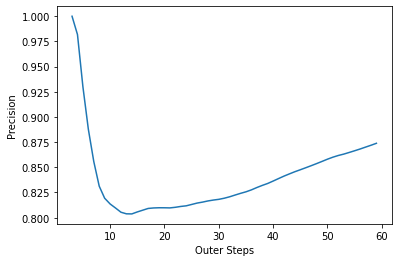

In [ ]:
plt.plot(precision_log_scratch)
plt.xlabel("Outer Steps")
plt.ylabel("Precision")

Text(0, 0.5, 'Recall')

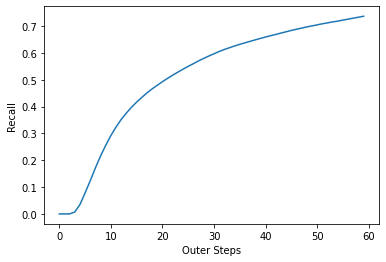

In [ ]:
plt.plot(recall_log_scratch)
plt.xlabel("Outer Steps")
plt.ylabel("Recall")

Text(0, 0.5, 'F-measure')

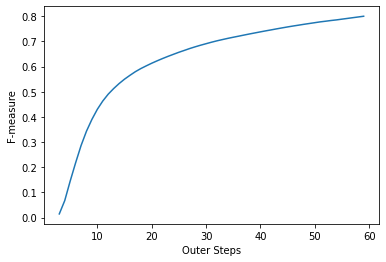

In [ ]:
plt.plot(fscore_log_scratch)
plt.xlabel("Outer Steps")
plt.ylabel("F-measure")

In [ ]:


# Optional
wandb.watch(model_federated_meta)

[]

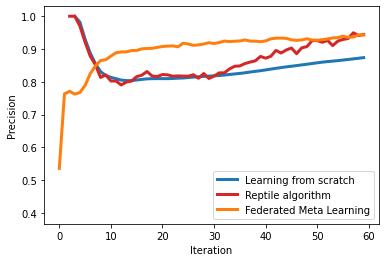

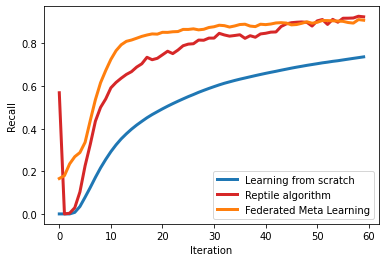

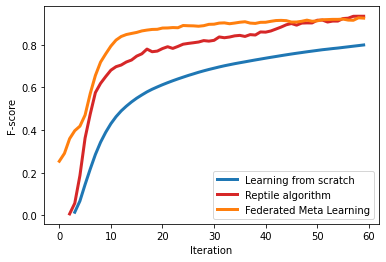

In [ ]:
#precision_t,recall_t,fscore_t,Test_loss
#plt.plot(Test_loss,'tab:blue', linewidth=3)
#plt.plot(Loss_avg,'tab:red', linewidth=3)
#plt.plot(Loss_avg,'tab:orange', linewidth=3)
#plt.legend(("Without Reptile","with Reptile")
#plt.xlabel("Inner Steps")
#plt.ylabel("Test loss")
#plt.legend(["Learning from scratch","Reptile algorithm","Federated Meta Learning"])
#plt.figure()

plt.plot(precision_log_scratch,'tab:blue', linewidth=3)
plt.plot(precision_log_reptile,'tab:red', linewidth=3)
plt.plot(precision_log_federated_meta,'tab:orange', linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.legend(["Learning from scratch","Reptile algorithm","Federated Meta Learning"])
plt.figure()
plt.plot(recall_log_scratch,'tab:blue', linewidth=3)
plt.plot(recall_log_reptile,'tab:red', linewidth=3)
plt.plot(recall_log_federated_meta,'tab:orange', linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Recall")
plt.legend(["Learning from scratch","Reptile algorithm","Federated Meta Learning"])
plt.figure()
plt.plot(fscore_log_scratch,'tab:blue', linewidth=3)
plt.plot(fscore_log_reptile,'tab:red', linewidth=3)
plt.plot(fscore_log_federated_meta,'tab:orange', linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("F-score")
plt.legend(["Learning from scratch","Reptile algorithm","Federated Meta Learning"])

In [ ]:
'''a=weights_dict['weights'][widx]
b=Temp_model
B=[]
for wei in weights_dict['weights'][widx]:
  B.append(weights_dict['weights'][widx][wei]-Temp_model[wei])
print(B)'''

"a=weights_dict['weights'][widx]\nb=Temp_model\nB=[]\nfor wei in weights_dict['weights'][widx]:\n  B.append(weights_dict['weights'][widx][wei]-Temp_model[wei])\nprint(B)"

### Model saving examples

I try to find better ways to register models for each worker, and call them later.

OpenAI example code for training

In [ ]:
'''# Reptile training loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})'''

'# Reptile training loop\nfor iteration in range(niterations):\n    weights_before = deepcopy(model.state_dict())\n    # Generate task\n    f = gen_task()\n    y_all = f(x_all)\n    # Do SGD on this task\n    inds = rng.permutation(len(x_all))\n    for _ in range(innerepochs):\n        for start in range(0, len(x_all), ntrain):\n            mbinds = inds[start:start+ntrain]\n            train_on_batch(x_all[mbinds], y_all[mbinds])\n    # Interpolate between current weights and trained weights from this task\n    # I.e. (weights_before - weights_after) is the meta-gradient\n    weights_after = model.state_dict()\n    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule\n    model.load_state_dict({name : \n        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize \n        for name in weights_before})'

In [ ]:
'''##### TASK 3 for Test #####
# *For scenario 1 aggregate in FL framework. Scenario 2 updates in reptile algorithm
recall_meta=np.zeros([num_worker,Meta_step_number])
Loss_meta=np.zeros([num_worker,Meta_step_number])
precision_meta=np.zeros([num_worker,Meta_step_number])
fscore_meta=np.zeros([num_worker,Meta_step_number])


net_Fed_meta.state_dict=initial_weights
precision_fed,recall_fed,fscore_fed,Loss_fed=[],[],[],[]
TP_total,FP_total,TN_total,FN_total=0,0,0,0
for k in range(K_shot):
  precision_fed,recall_fed,fscore_fed,Loss_fed=[],[],[],[]
  TP_total,FP_total,TN_total,FN_total=0,0,0,0
  for widx in range(num_worker):
    net_Fed_meta.state_dict=weights_dict['weights'][widx]
    #testloader=torch.utils.data.DataLoader(test_subset[0], batch_size=20,shuffle=True, num_workers=2)
                                              
    for i, data in enumerate(testloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels_maml=Meta_labels(labels,3)#Initial adaptaion to task 3
        optimizer_Fed_meta.zero_grad(set_to_none=True)
        outputs = net_Fed_meta(inputs)
        loss = criterion(outputs, labels_maml.float())
        loss.backward()
        optimizer_Fed_meta.step()
        ## Logging results data
        Loss_fed.append(loss.item())
        TP,FP,TN,FN = extractor(labels_maml,outputs)
        TP_total,FP_total,TN_total,FN_total=np.add([TP_total,FP_total,TN_total,FN_total],[TP,FP,TN,FN]) 
        precision_f,recall_f,fscore_f=Accuracy_calculation(TP_total,FP_total,TN_total,FN_total)
        recall_meta[widx,i-1]=recall_f
        Loss_meta[widx,i-1]=loss.item()
        precision_meta[widx,i-1]=precision_f
        fscore_meta[widx,i-1]=fscore_f
        precision_fed.append(precision_f)
        recall_fed.append(recall_f)
        fscore_fed.append(fscore_f)
        if i %100==Meta_step_number:
          if widx==num_worker-1:
              for idx in range(widx):
                weights_dict['weights'][idx]=FedAvg(weights_dict['weights'],num_worker)
          break

  for wei in weights_dict['weights'][widx]:
      initial_weights[wei]= initial_weights[wei] +  Beta*(weights_dict['weights'][widx][wei]-initial_weights[wei])
recall_avg=np.zeros(Meta_step_number)
Loss_avg=np.zeros(Meta_step_number)
precision_avg=np.zeros(Meta_step_number)
fscore_avg=np.zeros(Meta_step_number)
#Averaging performance values of task 3 accross the workers 
for j in range(Meta_step_number): 
  recall_avg[j]=np.mean(recall_fed[j::Meta_step_number])
  Loss_avg[j]=np.mean(Loss_fed[j::Meta_step_number])
  precision_avg[j]=np.mean(precision_fed[j::Meta_step_number])
  fscore_avg[j]=np.mean(fscore_fed[j::Meta_step_number])'''

"##### TASK 3 for Test #####\n# *For scenario 1 aggregate in FL framework. Scenario 2 updates in reptile algorithm\nrecall_meta=np.zeros([num_worker,Meta_step_number])\nLoss_meta=np.zeros([num_worker,Meta_step_number])\nprecision_meta=np.zeros([num_worker,Meta_step_number])\nfscore_meta=np.zeros([num_worker,Meta_step_number])\n\n\nnet_Fed_meta.state_dict=initial_weights\nprecision_fed,recall_fed,fscore_fed,Loss_fed=[],[],[],[]\nTP_total,FP_total,TN_total,FN_total=0,0,0,0\nfor k in range(K_shot):\n  precision_fed,recall_fed,fscore_fed,Loss_fed=[],[],[],[]\n  TP_total,FP_total,TN_total,FN_total=0,0,0,0\n  for widx in range(num_worker):\n    net_Fed_meta.state_dict=weights_dict['weights'][widx]\n    #testloader=torch.utils.data.DataLoader(test_subset[0], batch_size=20,shuffle=True, num_workers=2)\n                                              \n    for i, data in enumerate(testloader,0):\n        # get the inputs; data is a list of [inputs, labels]\n        inputs, labels = data\n        